In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# IMU 데이터 읽기
def read_imu_data(file_path):
    imu_data = pd.read_csv(file_path, delim_whitespace=True)
    imu_data['dt'] = imu_data['Time'] - imu_data['Time'].shift(1)
    imu_data = imu_data.iloc[1:].reset_index(drop=True)  # 첫 번째 행을 제거
    return imu_data

# GPS 데이터 읽기
def read_gps_data(file_path):
    gps_data = pd.read_csv(file_path)
    gps_data['dt'] = gps_data['Time'] - gps_data['Time'].shift(1)
    gps_data = gps_data.iloc[1:].reset_index(drop=True)  # 첫 번째 행을 제거
    return gps_data

# IMU 데이터 보간
def interpolate_imu_data(gps_time, imu_data):
    if len(imu_data) < 2:
        return None
    
    imu_data_times = imu_data['Time'].values
    
    # 찾을 IMU 데이터의 인덱스
    idx = np.searchsorted(imu_data_times, gps_time, side='right')
    
    if idx == 0 or idx >= len(imu_data):
        return None
    
    # 보간할 두 IMU 데이터
    imu_data_prev = imu_data.iloc[idx - 1]
    imu_data_next = imu_data.iloc[idx]
    
    # 시간 비율 계산
    t_prev = imu_data_prev['Time']
    t_next = imu_data_next['Time']
    ratio = (gps_time - t_prev) / (t_next - t_prev)
    
    interpolated_imu = {}
    interpolated_imu['Time'] = gps_time
    for key in imu_data_prev.keys():
        if key != 'Time' and key != 'dt':
            interpolated_imu[key] = imu_data_prev[key] + ratio * (imu_data_next[key] - imu_data_prev[key])
    
    return interpolated_imu

# 파일 경로 설정
imu_file_path = 'KittiEquivBiasedImu.txt'
gps_file_path = 'KittiGps_converted.txt'

# 데이터 읽기
imu_data = read_imu_data(imu_file_path)
gps_data = read_gps_data(gps_file_path)

# 보간된 IMU 데이터를 저장할 리스트
interpolated_imu_data = []

# GPS 데이터에 맞춰 IMU 데이터 보간
for i in range(len(gps_data)):
    gps_time = gps_data.iloc[i]['Time']
    interpolated_imu = interpolate_imu_data(gps_time, imu_data)
    if interpolated_imu is not None:
        interpolated_imu_data.append(interpolated_imu)

# 보간된 IMU 데이터를 데이터프레임으로 변환
interpolated_imu_df = pd.DataFrame(interpolated_imu_data)

print("보간된 IMU 데이터:")
print(interpolated_imu_df.head())

print("GPS 데이터:")
print(gps_data.head())


보간된 IMU 데이터:
           Time    accelX    accelY     accelZ    omegaX    omegaY    omegaZ
0  46537.387955  0.416185  0.402181   9.776328  0.012925 -0.006779  0.010842
1  46538.387785  0.608107  0.190645  10.264964  0.019876  0.018885 -0.005360
2  46539.387628 -0.080750  0.543204   9.451487 -0.003678  0.020408  0.008915
3  46540.387861 -0.500742  0.375906   9.619599 -0.026245 -0.034160  0.007322
4  46541.387442 -0.618689  0.897772   9.345673  0.003169  0.044608  0.007952
GPS 데이터:
           Time          X          Y         Z        dt
0  46537.387955   3.897116   7.545074  0.024788  2.909580
1  46538.387785   8.078858  15.642044  0.029816  0.999830
2  46539.387628  12.549835  24.282061  0.129593  0.999842
3  46540.387861  16.916268  32.965313  0.170364  1.000234
4  46541.387442  21.110495  41.307726  0.190109  0.999580


In [5]:
import numpy as np
from filterpy.kalman import KalmanFilter

# 칼만 필터 초기화
kf = KalmanFilter(dim_x=9, dim_z=3)

# 상태 전이 행렬 (State Transition Matrix)
dt = 1.0  # 시간 간격 (초)
kf.F = np.array([[1, dt, 0,  0, 0, 0,  0, 0, 0],
                 [0,  1, 0,  0, 0, 0,  0, 0, 0],
                 [0,  0, 1, dt, 0, 0,  0, 0, 0],
                 [0,  0, 0,  1, 0, 0,  0, 0, 0],
                 [0,  0, 0,  0, 1, dt, 0, 0, 0],
                 [0,  0, 0,  0, 0, 1,  0, 0, 0],
                 [0,  0, 0,  0, 0, 0,  1, dt, 0],
                 [0,  0, 0,  0, 0, 0,  0, 1, dt],
                 [0,  0, 0,  0, 0, 0,  0, 0, 1]])

# 측정 행렬 (Measurement Matrix)
kf.H = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 1, 0, 0, 0, 0]])

# 초기 상태 추정값
kf.x = np.zeros(9)

# 초기 오차 공분산 행렬 (Initial Covariance Matrix)
kf.P *= 1000.

# 프로세스 잡음 행렬 (Process Noise Matrix)
kf.Q = np.eye(9) * 0.1

# 측정 잡음 행렬 (Measurement Noise Matrix)
kf.R = np.eye(3) * 5.

# 데이터 융합 결과를 저장할 리스트
filtered_data = []

# 데이터 융합
for i in range(len(gps_data)):
    # 시간 간격 업데이트
    dt = gps_data.iloc[i]['dt']
    kf.F[0, 1] = dt
    kf.F[3, 4] = dt
    kf.F[6, 7] = dt
    
    # 측정값 (GPS 데이터)
    z = np.array([gps_data.iloc[i]['X'], gps_data.iloc[i]['Y'], gps_data.iloc[i]['Z']])
    
    # 예측 단계
    kf.predict()
    
    # 업데이트 단계
    kf.update(z)
    
    # 결과 저장
    filtered_data.append(kf.x.copy())
    
    # 결과 출력
    print(f"시간 {gps_data.iloc[i]['Time']}의 상태 추정값: {kf.x}")

# 최종 상태 추정값
print("최종 상태 추정값:")
print(kf.x)

# 필터링 결과를 데이터프레임으로 변환
filtered_df = pd.DataFrame(filtered_data, columns=['X', 'VX', 'Y', 'VY', 'Z', 'VZ', 'AX', 'AY', 'AZ'])


시간 46537.387955333의 상태 추정값: [3.89505805 1.19726144 7.52625914 3.79891089 0.02472609 0.01236243
 0.         0.         0.        ]
시간 46538.387785226의 상태 추정값: [ 7.95374238  3.89336404 15.6123512   8.23295159 -0.05312615 -0.24669833
  0.          0.          0.        ]
시간 46539.387627609의 상태 추정값: [12.42414748  4.23469711 24.20895177  8.57438855  0.033405   -0.08757734
  0.          0.          0.        ]
시간 46540.387861144의 상태 추정값: [16.83920848  4.31181806 32.92479278  8.79503011  0.09943953 -0.03464756
  0.          0.          0.        ]
시간 46541.38744151의 상태 추정값: [2.11256509e+01 4.30370912e+00 4.14235567e+01 8.76672897e+00
 1.19609129e-01 2.16928524e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
시간 46542.387289406의 상태 추정값: [2.51781855e+01 4.22963974e+00 4.94085542e+01 8.40957703e+00
 6.40294850e-02 2.38676259e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
시간 46543.38717555의 상태 추정값: [ 2.87943785e+01  4.06471430e+00  5.63718108e+01  7.56375246e+00
 -7.44895688e-02  4.20421713

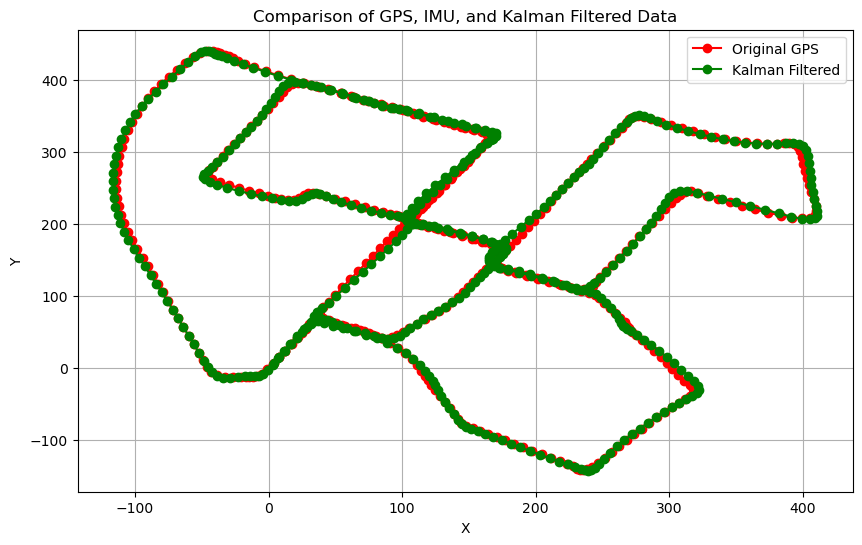

In [7]:
import dash
from dash import dcc, html
import plotly.graph_objs as go



In [12]:
# 이를 바탕으로 IMU 데이터와 GPS 데이터를 Extended Kalman Filter로 퓨전

# 필요한 라이브러리 불러오기
import numpy as np
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

# 상태 전이 함수

def fx(X, Y, Z, 


